### Import Libraries

In [62]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

### Import Dataset

In [63]:
# Read Dataset
df = pd.read_excel("Historic.xlsx", sheet_name = 1)

# Drop Null Values
df = df.dropna()

# Drop Unnecessary Columns
df = df[df.columns.drop(["G-G-Loops", "O-R"])]

# Combine Year, Month and Date Column to form Date
df["Date"] = df[['Year', 'Month', 'Day']].apply(lambda x: '{}-{}-{}'.format(x[0], x[1], x[2]), axis=1)

# Drop Year, Month and Day Column
df = df[df.columns.drop(['Year', 'Month', 'Day'])]

# Convert Date Column type to Datetime
df["Date"] = pd.to_datetime(df["Date"])

# Set Date Column as Index
df = df.set_index("Date")

df.head()

,O-O-S
Date,
2021-01-01,42.0
2021-01-02,52.0
2021-01-03,83.0
2021-01-04,204.0
2021-01-05,216.0


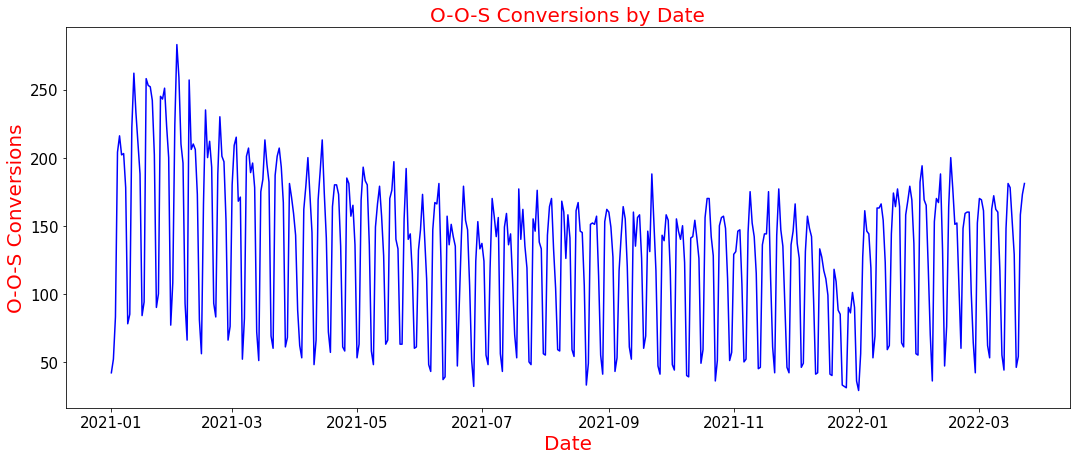

In [64]:
plt.figure(figsize = (18, 7))
sns.lineplot(x = df.index, y = "O-O-S", data = df, color = "blue")
plt.title("O-O-S Conversions by Date", color = "red", size = 20)
plt.xlabel("Date", color = "red", size = 20)
plt.ylabel("O-O-S Conversions", color = "red", size = 20)
plt.yticks(size = 15)
plt.xticks(size = 15)
plt.show()

### Applying the Adfuller Test (Test for trend non-stationary)

**<code>Null Hypothesis:</code>**      Time Series has Trend <p>
**<code>Alternate Hypothesis:</code>** Time Series is stationary

In [65]:
results = adfuller(df["O-O-S"])
pd.DataFrame({"Values": results,
              "Statistics": ["Test Statistics", "P-Value", "Used Lag", "Observations", "Critical Values", "icbest"]})

,Values,Statistics
0,-2.446853,Test Statistics
1,0.128947,P-Value
2,14,Used Lag
3,429,Observations
4,"{'1%': -3.445685337552546, '5%': -2.8683008089...",Critical Values
5,3756.553699,icbest


In [66]:
if results[1] > 0.05:
    print("Accept Null Hypothesis: Amazon Time Series has Trend")
else:
    print("Accept Alternate Hypothesis: Amazon Time Series is Stationary")

Accept Null Hypothesis: Amazon Time Series has Trend


### ACF Plot

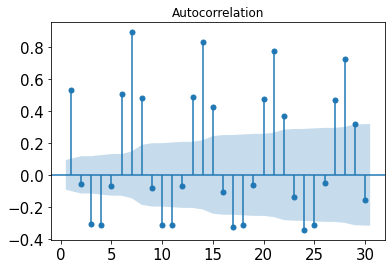

In [67]:
plot_acf(df, lags = 30, zero = False)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

### PACF Plot

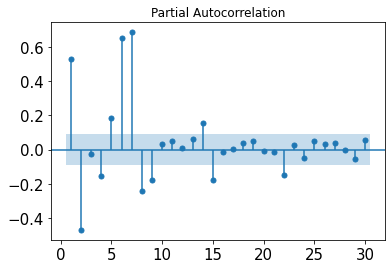

In [68]:
plot_pacf(df, lags = 30, zero = False)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

### Automated Model Selection

In [69]:
# Create auto_arima model
model = pm.auto_arima(df,
                      seasonal=True,m=7,
                      d=0, 
                      D = 1, # Seasonal Differencing
                 	  max_p=3, max_q=3,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True)
                       
# Print model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[7] intercept   : AIC=3920.251, Time=1.28 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=4004.357, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=3928.400, Time=0.25 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=3930.245, Time=0.17 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=4002.405, Time=0.02 sec
 ARIMA(2,0,2)(0,1,1)[7] intercept   : AIC=3918.287, Time=0.92 sec
 ARIMA(2,0,2)(0,1,0)[7] intercept   : AIC=3968.489, Time=0.37 sec
 ARIMA(2,0,2)(0,1,2)[7] intercept   : AIC=3920.256, Time=1.72 sec
 ARIMA(2,0,2)(1,1,0)[7] intercept   : AIC=3927.317, Time=0.69 sec
 ARIMA(2,0,2)(1,1,2)[7] intercept   : AIC=3922.245, Time=1.81 sec
 ARIMA(1,0,2)(0,1,1)[7] intercept   : AIC=3917.310, Time=0.45 sec
 ARIMA(1,0,2)(0,1,0)[7] intercept   : AIC=3969.885, Time=0.31 sec
 ARIMA(1,0,2)(1,1,1)[7] intercept   : AIC=3919.263, Time=0.75 sec
 ARIMA(1,0,2)(0,1,2)[7] intercept   : AIC=3919.269, Time=0.75 sec
 ARIMA(1,0,2)(1,1,0)[7] intercept

In [70]:
# Create model object
model = SARIMAX(df, 
                order=(1, 0, 1), 
                seasonal_order=(0, 1, 1, 7))
# Fit model
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             O-O-S   No. Observations:                  444
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -1952.739
Date:                           Sun, 27 Mar 2022   AIC                           3913.478
Time:                                   12:56:47   BIC                           3929.798
Sample:                                        0   HQIC                          3919.918
                                           - 444                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6396      0.079      8.084      0.000       0.485       0.795
ma.L1         -0.3352      0.097     -3.464      0.001      -0.525      -0.146
ma.S.L7       -0.3993      0.034    -11.819      0.000      -0.466      -0.333
sigma2       444.1277     19.628     22.627      0.000     405.658     482.598
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):               301.51
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.48
Prob(H) (two-sided):                  0.96   Kurtosis:                         6.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

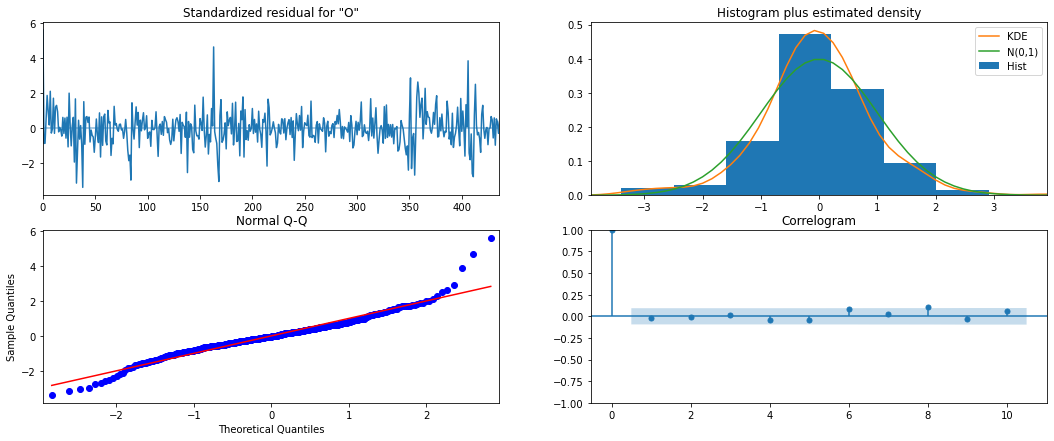

In [71]:
results.plot_diagnostics(figsize = (18, 7))
plt.show()

In [72]:
# Create forecast object
forecast_object = results.get_forecast(283)

# Extract predicted mean attribute
mean = forecast_object.predicted_mean

mean = pd.DataFrame(mean)
mean = mean.set_index(pd.date_range(start='3/24/2022', end='12/31/2022'))

# Calculate the confidence intervals
conf_int = forecast_object.conf_int()

# Extract the forecast dates
dates = mean.index

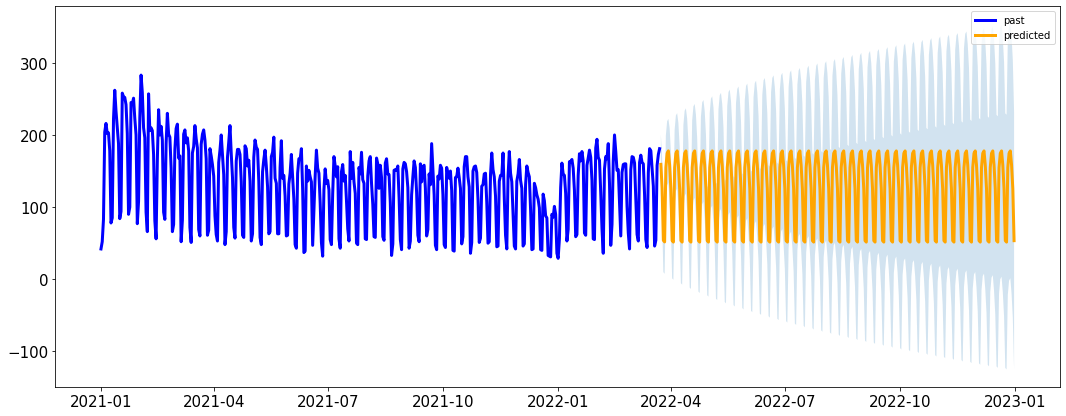

In [73]:
plt.figure(figsize = (18, 7))

# Plot past CO2 levels
plt.plot(df.index, df, label='past', linewidth = 3, color = "blue")

# Plot the prediction means as line
plt.plot(dates, mean["predicted_mean"], label='predicted', linewidth = 3, color = "orange")

# Shade between the confidence intervals
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.2)
plt.xticks(size = 15)
plt.yticks(size = 15)
# Plot legend and show figure
plt.legend()
plt.show()